In [1]:
import sys
sys.path.insert(1, '../')
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import cmath
from scipy.io import loadmat
from numpy.fft import fft, ifft
import random
import matplotlib as mpl
from attributedict.collections import AttributeDict



mpl.rcParams['figure.figsize'] = (19, 6) 
pi = np.pi

In [2]:
data = loadmat("../emptyEEG.mat")   
eeg = data['EEG']
gridloc = data['lf']['GridLoc'][0][0]
gain = data['lf']['Gain'][0][0]
srate = eeg['srate'][0][0][0][0]
nbchan = eeg['nbchan'].item().item()

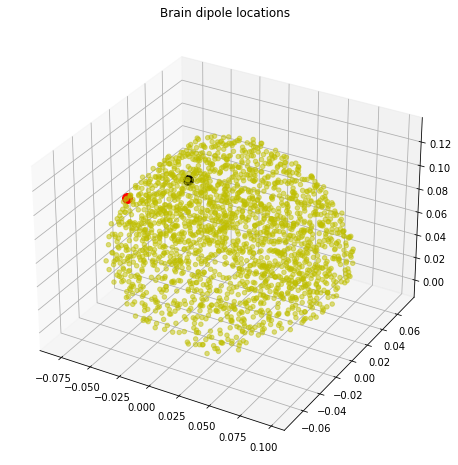

In [3]:
# % select dipole location
diploc1 = 109
diploc2 = 118

# plot brain dipoles
fig = plt.figure(1, figsize=(15,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(gridloc[:,0], gridloc[:,1], gridloc[:,2], c='y', alpha=0.5)
ax.scatter(gridloc[diploc1,0], gridloc[diploc1,1], gridloc[diploc1,2], c='k', s=100)
ax.scatter(gridloc[diploc2,0], gridloc[diploc2,1], gridloc[diploc2,2], c='r', s=100)
ax.set_title('Brain dipole locations')
plt.show()

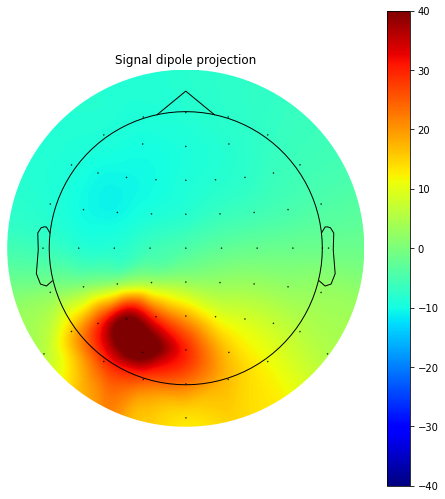

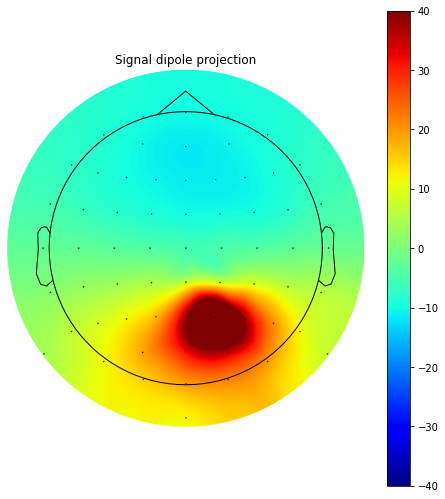

In [16]:
# % Each dipole can be projected onto the scalp using the forward model. 
# % The code below shows this projection from one dipole.

topoPlotIndie(data['EEG'], -gain[:, 0, diploc1], contours=0, title='Signal dipole projection', vlim=[-40,40], cmap="jet")
topoPlotIndie(data['EEG'], -gain[:, 0, diploc2], contours=0, title='Signal dipole projection', vlim=[-40,40], cmap="jet")

In [5]:
EEG = AttributeDict()

EEG.pnts   = 1143
EEG.trials = 150
EEG.srate = srate
EEG.nbchan = nbchan
EEG.times  = np.arange(EEG.pnts)/EEG.srate - .2
EEG.data = np.zeros((EEG.nbchan, EEG.pnts, EEG.trials))

In [6]:
# Gaussian 
peaktime = 0.5
fwhm = 0.12

gaus = np.exp(-(4*np.log(2)*(EEG.times - peaktime)**2) / fwhm**2)
sinefreq1 = 9
sinefreq2 = 14

sine1 = np.sin(2*pi*sinefreq1*EEG.times)
sine2 = np.sin(2*pi*sinefreq2*EEG.times)

for triali in range(EEG.trials):
    # initialize dipole data
    dipdat = 0.01 * np.random.randn(gain.shape[2], EEG.pnts)
    
    dipdat[diploc1, :] = sine1 * gaus
    dipdat[diploc2, :] = sine2 * gaus
    
    # compute one trial
    EEG.data[:,:,triali] = np.squeeze(gain[:,0,:]) @ dipdat
    


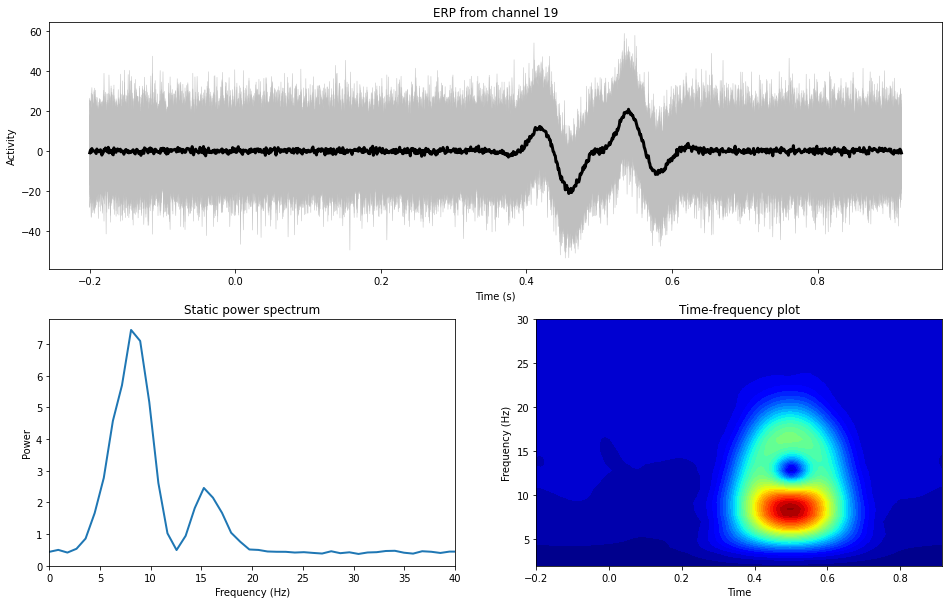

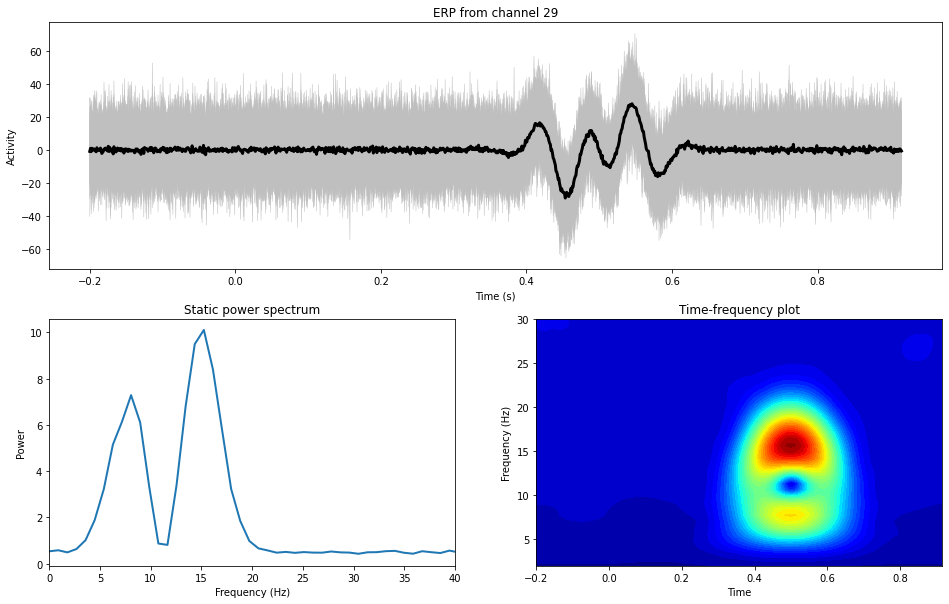

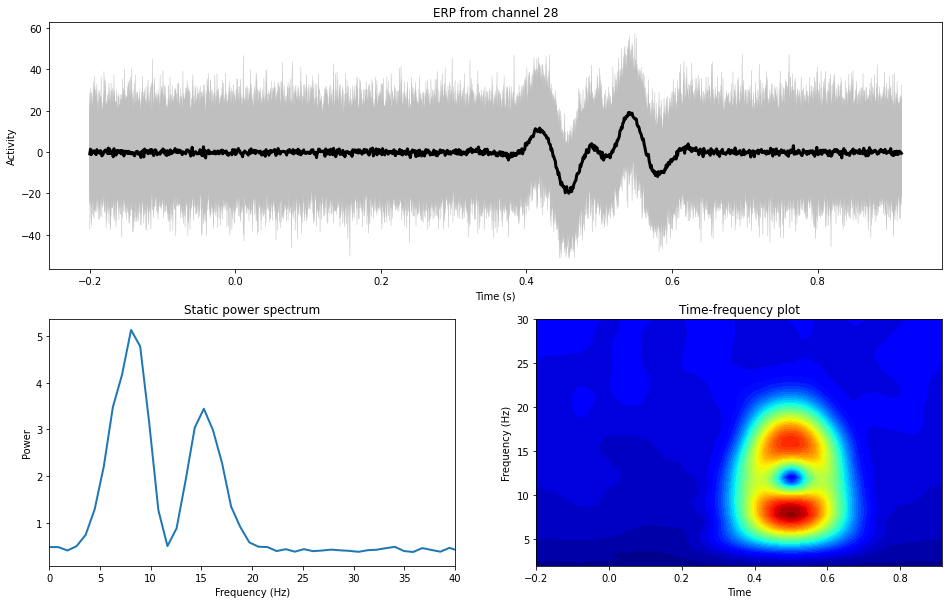

In [7]:
# try a few channels
plot_simEEG(EEG, 19, 1)
plot_simEEG(EEG, 29, 1)
plot_simEEG(EEG, 28, 1)

In [8]:
EEG.data.shape

(64, 1143, 150)

In [9]:
def ftoi(freq):
    return np.argmin(np.abs(hz - freq))

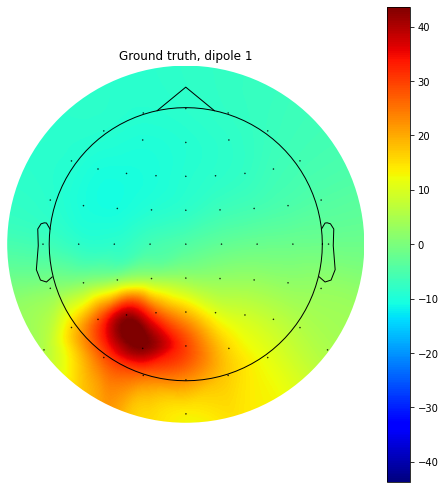

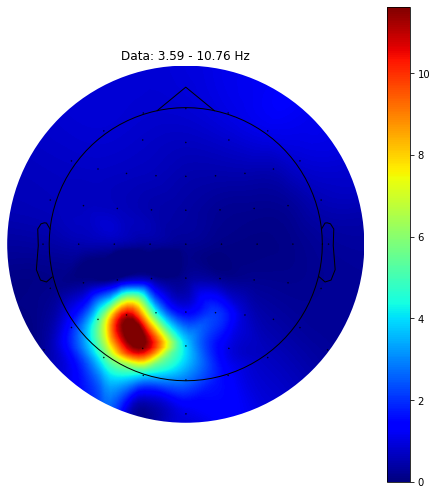

In [14]:

# %%%
# % now for the project...
# %%%

# %% 

# % FFT over all channels
fourierCoeffs = fft(EEG.data, axis=1) / EEG.pnts
powerSpectra = np.mean( (2*(abs(fourierCoeffs)))**2, axis=2)

# % vector of frequencies
hz = np.linspace(0, EEG.srate/2, EEG.pnts//2+1)

# % frequency cutoffs in Hz and indices
lowband = [3.59, 10.76]
highband = [10.76, 19.73]

lowbandInds = [ftoi(lowband[0]), ftoi(lowband[1])]
highbandInds = [ftoi(highband[0]), ftoi(highband[1])]

# % power in first spectral window
powerLowBand = powerSpectra[:, lowbandInds[0]:lowbandInds[1]+1]
powerLowBand = np.mean(powerLowBand, axis=1)

powerHighBand = powerSpectra[:, highbandInds[0]:highbandInds[1]+1]
powerHighBand = np.mean(powerHighBand, axis=1)

# topographical plots of dipole projections and band-specific power.
topoPlotIndie(data['EEG'], -gain[:, 0, diploc1], contours=0, title=f"Ground truth, dipole 1", cmap="jet")
topoPlotIndie(data['EEG'], powerLowBand, contours=0, title=f"Data: {lowband[0]} - {lowband[1]} Hz", cmap="jet")

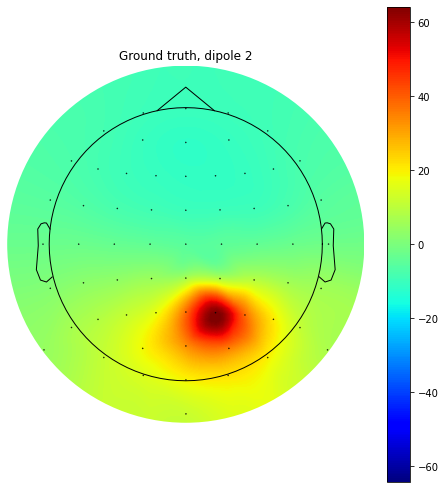

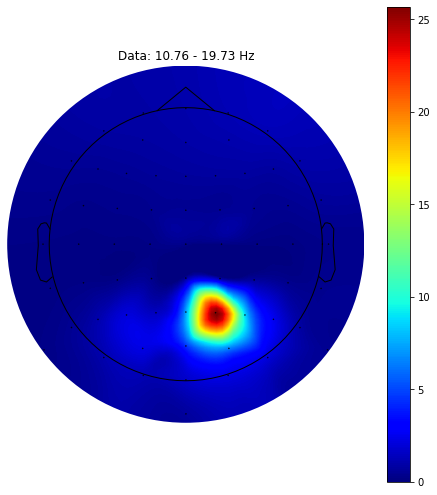

In [15]:
topoPlotIndie(data['EEG'], -gain[:, 0, diploc2], contours=0, title=f"Ground truth, dipole 2", cmap="jet")
topoPlotIndie(data['EEG'], powerHighBand, contours=0, title=f"Data: {highband[0]} - {highband[1]} Hz", cmap="jet")

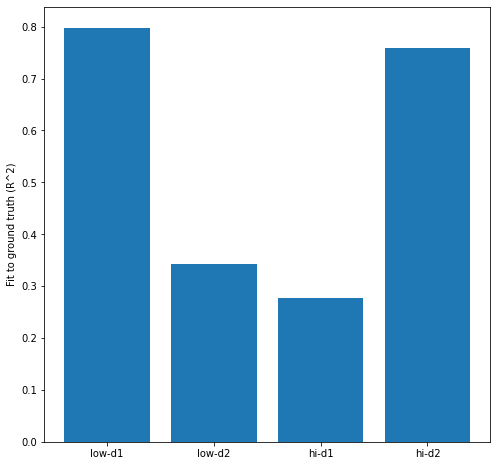

In [12]:
# %% quantify fit via R2

# % data to each dipole projection
loband2dip1 = -np.corrcoef( powerLowBand, gain[:, 0, diploc1] )[1][0]
loband2dip2 = -np.corrcoef( powerLowBand, gain[:, 0, diploc2] )[1][0]
hiband2dip1 = -np.corrcoef( powerHighBand, gain[:, 0, diploc1] )[1][0]
hiband2dip2 = -np.corrcoef( powerHighBand, gain[:, 0, diploc2] )[1][0]


# % data to each dipole projection
x_values = range(4)
y_values = [loband2dip1, loband2dip2, hiband2dip1, hiband2dip2]
x_labels = ['low-d1', 'low-d2', 'hi-d1', 'hi-d2']

plt.figure(figsize=(8,8))
plt.bar(x_values, y_values, tick_label=x_labels)
plt.ylabel('Fit to ground truth (R^2)')
plt.show()